In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt
import gc

import utils as pic

%load_ext autoreload
%autoreload 2

In [2]:
lr_init     = 1.e-2   # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 5000     # Training size
valid_size  = 2500     # Validation size
test_size   = 2500     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff

In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [4]:
def build_hit_sequence(X,low_e=0.05,abstime=0.02):
    index_map = np.indices((32, 32)).reshape(2,1,32*32)
    X = pic.remove_empty_pixels(X,low_e,abstime).reshape(-1,32*32,2)
    hit_e = X[:,:,0].reshape(-1,32*32,1)
    hit_t = X[:,:,1].reshape(-1,32*32,1)
    hit_x = np.where(~np.isnan(X[:,:,0]),index_map[0],np.nan).reshape(-1,32*32,1)
    hit_y = np.where(~np.isnan(X[:,:,0]),index_map[1],np.nan).reshape(-1,32*32,1)
    hit_features = np.concatenate([hit_e,hit_t,hit_x,hit_y],axis=-1)
    timeorder = hit_features[:,:,1].argsort()
    for i,(features,order) in enumerate(zip(hit_features,timeorder)):
        hit_features[i,:,:] = features[order]
    maxhits = np.max(np.sum(~np.isnan(hit_features[:,:,0]),axis=-1))
    return hit_features[:,:maxhits,:],maxhits

In [5]:
from sklearn.preprocessing import MinMaxScaler
X_train,maxhits = build_hit_sequence(X_train)

scaler = MinMaxScaler().fit(X_train.reshape(-1,4))

maskint = 69
def scale_and_mask(features,maxhits):
    scaled = scaler.transform( features.reshape(-1,4) ).reshape(-1,maxhits,4)
    masked = np.where(np.isnan(scaled),maskint,scaled)
    return masked


X_train = scale_and_mask(X_train,maxhits)
y_b_train = to_categorical(y_train)
X_train.shape

(10000, 26, 4)

In [6]:
X_valid = scale_and_mask(*build_hit_sequence(X_valid))
y_b_valid = to_categorical(y_valid)

In [7]:
X_test = scale_and_mask(*build_hit_sequence(X_test))
y_b_test = to_categorical(y_test)

In [8]:
model = keras.Sequential()

model.add(layers.Masking(mask_value=maskint,input_shape=(None,4)))
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.ReLU())
model.add(layers.Dense(128))
model.add(layers.ReLU())
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.ReLU())
model.add(layers.Dense(64))
model.add(layers.ReLU())
model.add(layers.LSTM(32))
model.add(layers.ReLU())
model.add(layers.Dense(32))
model.add(layers.ReLU())
model.add(layers.Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         68096     
_________________________________________________________________
re_lu (ReLU)                 (None, None, 128)         0         
_________________________________________________________________
dense (Dense)                (None, None, 128)         16512     
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
re_lu_2 (ReLU)               (None, None, 64)          0

In [9]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=lr_init),metrics=['accuracy'])

In [10]:
history = model.fit(
    X_train, y_b_train,
    validation_data=(X_valid,y_b_valid),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/20
100/100 [==============================] - 15s 95ms/step - loss: 0.6900 - accuracy: 0.5418 - val_loss: 0.6900 - val_accuracy: 0.5474
Epoch 2/20
100/100 [==============================] - 8s 78ms/step - loss: 0.6867 - accuracy: 0.5426 - val_loss: 0.6866 - val_accuracy: 0.5448
Epoch 3/20
100/100 [==============================] - 8s 77ms/step - loss: 0.6867 - accuracy: 0.5477 - val_loss: 0.6869 - val_accuracy: 0.5448
Epoch 4/20
100/100 [==============================] - 8s 83ms/step - loss: 0.6864 - accuracy: 0.5482 - val_loss: 0.6872 - val_accuracy: 0.5474
Epoch 5/20
100/100 [==============================] - 8s 77ms/step - loss: 0.6867 - accuracy: 0.5453 - val_loss: 0.6876 - val_accuracy: 0.5448
Epoch 6/20
100/100 [==============================] - 7s 72ms/step - loss: 0.6865 - accuracy: 0.5557 - val_loss: 0.6870 - val_accuracy: 0.5448
Epoch 7/20
100/100 [==============================] - 7s 72ms/step - loss: 0.6862 - accuracy: 0.5484 - val_loss: 0.6864 - val_accuracy: 0.547

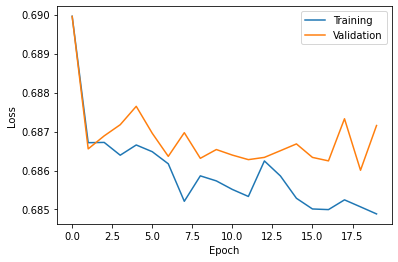

In [11]:
pic.plot_history(history)

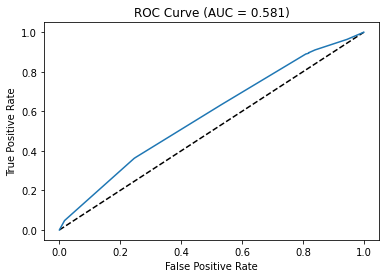

In [12]:
pic.plot_roc(y_b_test[:,0],model.predict(X_test)[:,0])